# Ejemplo - Calibración de un modelo hidrológico

## Paso 1: Generar el modelo

<center><img src="HYMOD.png" width="700"/><center>    

### Importar librerías, elementos y algoritmos para construir el modelo

In [80]:
import numpy as np
import matplotlib.pyplot as plt

from superflexpy.implementation.root_finders.pegasus import PegasusPython
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.elements.hymod import UpperZone, LinearReservoir
from superflexpy.implementation.elements.structure_elements import Junction, Splitter, Transparent
from superflexpy.framework.unit import Unit

### Generar modelo

In [185]:
def hymod(params, init):
    
    root_finder = PegasusPython()  # Use the default parameters
    numerical_approximation = ImplicitEulerPython(root_finder)

    upper_zone = UpperZone(parameters={'Smax': params['Smax'], 'm': params['m'], 'beta': params['beta']},
                           states={'S0': init['uz']},
                           approximation=numerical_approximation,
                           id='uz')

    splitter = Splitter(weight=[[params['alpha']], [1-params['alpha']]],
                        direction=[[0], [0]],
                        id='spl')

    channel_routing_1 = LinearReservoir(parameters={'k': params['k_ch1']},
                                        states={'S0': init['cr1']},
                                        approximation=numerical_approximation,
                                        id='cr1')

    channel_routing_2 = LinearReservoir(parameters={'k': params['k_ch2']},
                                        states={'S0': init['cr2']},
                                        approximation=numerical_approximation,
                                        id='cr2')

    channel_routing_3 = LinearReservoir(parameters={'k': params['k_ch3']},
                                        states={'S0': init['cr3']},
                                        approximation=numerical_approximation,
                                        id='cr3')

    lower_zone = LinearReservoir(parameters={'k': params['k_lz']},
                                 states={'S0': init['lz']},
                                 approximation=numerical_approximation,
                                 id='lz')

    transparent_1 = Transparent(id='tr1')

    transparent_2 = Transparent(id='tr2')

    junction = Junction(direction=[[0, 0]],  # First output
                        id='jun')

    model = Unit(layers=[[upper_zone],
                         [splitter],
                         [channel_routing_1, lower_zone],
                         [channel_routing_2, transparent_1],
                         [channel_routing_3, transparent_2],
                         [junction]],
                 id='model')
    
    return model

### Entradas y parámetros del modelo

In [190]:
# Read forcing data
data = np.loadtxt('data.csv', skiprows=1, delimiter=',')
P = data[:,0]
E = data[:,1]
obs = data[:,2]

A = 156 # Area (km2)

# Set parameters 
params = {'Smax':50.0,
          'm':0.8,
          'beta':2.0,
          'alpha':0.8,
          'k_ch1':0.5,
          'k_ch2':0.5,
          'k_ch3':0.5,
          'k_lz':0.3}

init = {'uz':10.0,
        'cr1':10.0,
        'cr2':10.0,
        'cr3':10.0,
        'lz':10.0}

# Generate model
model = hymod(params, init)

# Assign the input
model.set_input([P, E])

# Set the timestep
model.set_timestep(1.0)

# Run the model
model.reset_states()
output = model.get_output()

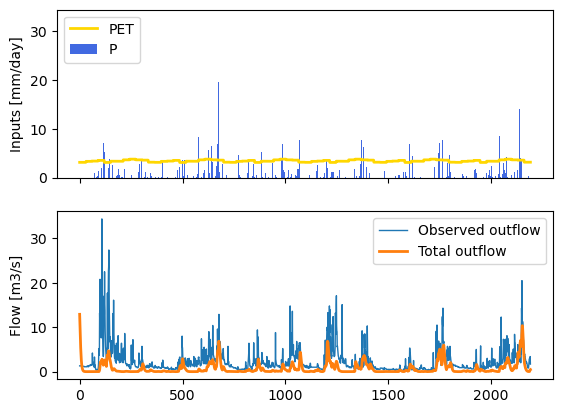

In [191]:
# Plot
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].bar(x=np.arange(len(P)), height=P, color='royalblue', label='P')
ax[0].plot(np.arange(len(P)), E, lw=2, color='gold', label='PET')
ax[0].legend()
ax[0].set_ylabel('Inputs [mm/day]')

ax[1].plot(np.arange(len(P)), obs, lw=1, label='Observed outflow')
ax[1].plot(np.arange(len(P)), output[0] * A * (1/(60*60*24)) * (1/1000) * (1000)**2, lw=2, label='Total outflow')
ax[1].legend()
ax[1].set_ylabel('Flow [m3/s]')

plt.show()

### Calibración

In [202]:
def rmse(obs, sim):
    res = obs - sim
    rmse = np.sqrt(res.dot(res)/len(res))
    return rmse

# Calibration ranges
Smax_range = [20, 200]
m_range = [0.1, 20]
beta_range = [0, 200]
alpha_range = [0.2, 1]
k_ch_range = [0.01, 0.5]
k_lz_range = [0.5, 2]
S0_range = [0, 10]

nsim = 1000 # Number of simulations
seed = 12345 # Random number seed
rng = np.random.default_rng(seed) # Random number generator

params = rng.uniform([Smax_range[0], m_range[0], beta_range[0], alpha_range[0], k_ch_range[0], k_lz_range[0], S0_range[0]],
                     [Smax_range[1], m_range[1], beta_range[1], alpha_range[1], k_ch_range[1], k_lz_range[1], S0_range[1]], 
                     (nsim, 7))

# Monte Carlo simulations
sim_out = []
rmse_out = []
for i, param_i in enumerate(params):
    # update parameters
    param = {'Smax':param_i[0],
             'm':param_i[1],
             'beta':param_i[2],
             'alpha':param_i[3],
             'k_ch1':param_i[4],
             'k_ch2':param_i[4],
             'k_ch3':param_i[4],
             'k_lz':param_i[5]}

    init = {'uz':param_i[6],
            'cr1':param_i[6],
            'cr2':param_i[6],
            'cr3':param_i[6],
            'lz':param_i[6]}
    
    # set up and run model
    model = hymod(param, init)
    model.set_input([P, E])
    model.set_timestep(1.0), 
    model.reset_states()
    
    # compute performance metric
    try:
        sim_i = model.get_output()[0]
        rmse_i = rmse(obs, sim_i)
    
    except:
        sim_i = []
        rmse_i = np.inf
    
    sim_out = sim_out + [sim_i]
    rmse_out = rmse_out + [rmse_i]
    
sim_out = np.array(sim_out, dtype=object)
rmse_out = np.array(rmse_out)

best_rmse = np.min(rmse_out)
best_params = params[np.where(rmse_out == best_rmse)][0]

In [206]:
best_rmse

2.6257153369336974

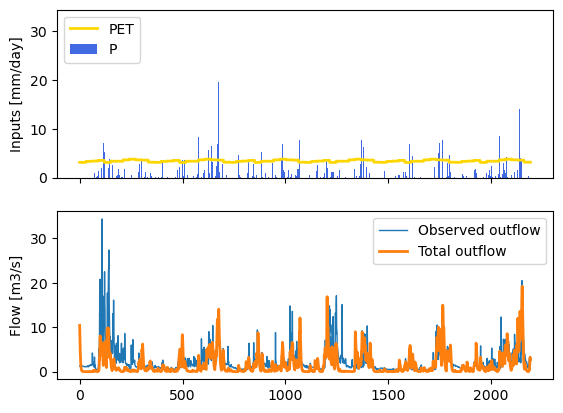

In [207]:
param = {'Smax':best_params[0],
         'm':best_params[1],
         'beta':best_params[2],
         'alpha':best_params[3],
         'k_ch1':best_params[4],
         'k_ch2':best_params[4],
         'k_ch3':best_params[4],
         'k_lz':best_params[5]}

init = {'uz':best_params[6],
        'cr1':best_params[6],
        'cr2':best_params[6],
        'cr3':best_params[6],
        'lz':best_params[6]}

# set up and run model
model = hymod(param, init)
model.set_input([P, E])
model.set_timestep(1.0), 
model.reset_states()

output = model.get_output()

# Plot
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].bar(x=np.arange(len(P)), height=P, color='royalblue', label='P')
ax[0].plot(np.arange(len(P)), E, lw=2, color='gold', label='PET')
ax[0].legend()
ax[0].set_ylabel('Inputs [mm/day]')

ax[1].plot(np.arange(len(P)), obs, lw=1, label='Observed outflow')
ax[1].plot(np.arange(len(P)), output[0] * A * (1/(60*60*24)) * (1/1000) * (1000)**2, lw=2, label='Total outflow')
ax[1].legend()
ax[1].set_ylabel('Flow [m3/s]')

plt.show()

In [208]:
best_params

array([197.20485506,  16.72536022, 177.13702909,   0.56158936,
         0.95927147,   0.36485159,   4.99577589])